<a href="https://colab.research.google.com/github/Yanina-Kutovaya/projects/blob/main/Car_insurance_renewal_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогноз пролонгации полиса автострахования.

## EDA

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install category_encoders -q

In [3]:
import pandas as pd
import numpy as np
import category_encoders as ce

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
PATH = '/content/drive/MyDrive/ML_projects/vsk/data/'

## 1. Чтение данных

In [6]:
data_file = 'Задание (пролонгация).xlsx'
field_description = pd.read_excel(PATH + data_file, 0, header=None)
data = pd.read_excel(PATH + data_file, 1)

In [7]:
field_description

,0,1
0,id,ID договора
1,Filial,Филиал продажи
2,Type_ts,Тип ТС
3,passport_region,Регион по серии паспорта
4,VIP,VIP клиент
5,Brand,Марка ТС
6,Model,Модель ТС
7,Yr_production,Год выпуска ТС
8,GAP,GAP застрахован
9,married,Брак


In [8]:
print(f'data.shape = {data.shape}\n')
data.sample(5)

data.shape = (10863, 30)



,ID,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,...,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
7542,7543,Московский,Иностранные,Москва,NaN,KIA,OPTIMA,2018,Нет,Состоит в браке,...,25,7,1.0,1400000,F,0,35000,0.025,0,1
1874,1875,Санкт - Петербургский,Иностранные,Санкт-Петербург,NaN,HYUNDAI,SOLARIS,2018,Нет,Не состоит в браке,...,52,24,1.0,600000,F,0,50000,0.065,1,0
4002,4003,Московский,Иностранные,Москва,NaN,NISSAN,X-TRAIL,2017,Нет,Состоит в браке,...,35,10,1.1,1400000,M,0,25000,0.015,1,0
3101,3102,Краснодарский,Иностранные,Краснодарский край,NaN,TOYOTA,LAND CRUISER PRADO 150,2018,Нет,Состоит в браке,...,57,30,1.1,3000000,F,1,70000,0.035,1,0
10750,10751,Тульский,Отечественные,Тульская область,NaN,LADA,GRANTA,2016,Нет,Состоит в браке,...,31,13,1.0,200000,M,0,10000,0.015,0,-1


In [9]:
TARGET_NAME = 'target'

## 2. Разделение на обучающую и тестовую выбоки

In [10]:
train = data[data[TARGET_NAME] != -1]
train.shape

(7598, 30)

In [11]:
test = data[data[TARGET_NAME] == -1]
test.shape

(3265, 30)

## 3. Распределение целевой переменной

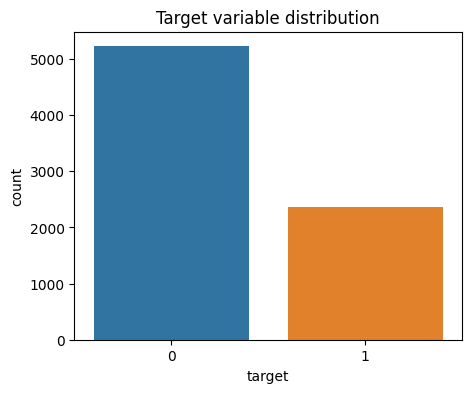

In [12]:
plt.figure(figsize=(5, 4))
sns.countplot(x=TARGET_NAME, data=train)
plt.title('Target variable distribution')
plt.show()

## 4. Числовые переменные

In [13]:
numeric_variables = (
    train.dtypes[data.dtypes != 'object']
    .drop(['ID', TARGET_NAME], axis=0)
    .index.tolist()
)
train[numeric_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
Yr_production,7598.0,2016.938668,1.549814,2009.0,2016.00,2018.00,2018.000,2018.0
KBM,7598.0,7.054488,1.924036,0.0,6.00,8.00,8.000,12.0
KBM_prol_est,7598.0,5.187418,1.732967,0.0,5.00,6.00,6.000,10.0
delta_kbm,7598.0,-5.065280,17.259945,-100.0,-2.00,-2.00,-2.000,2.0
Age,7598.0,43.727297,11.310642,18.0,35.00,42.00,52.000,83.0
Exp,7598.0,17.226375,9.653962,0.0,10.00,16.00,22.000,63.0
discount,7598.0,1.000559,0.050292,0.9,1.00,1.00,1.000,1.1
Amount - gr,7598.0,979626.217426,682881.387503,0.0,600000.00,800000.00,1200000.000,3000000.0
premium_car,7598.0,0.088576,0.284149,0.0,0.00,0.00,0.000,1.0
price_gr,7598.0,32769.807844,19740.598921,10000.0,15000.00,30000.00,45000.000,70000.0


In [14]:
numeric_info = train[numeric_variables].nunique()
numeric_info

Yr_production    10
KBM              13
KBM_prol_est     11
delta_kbm         6
Age              65
Exp              57
discount          5
Amount - gr      16
premium_car       2
price_gr         13
price_prc        21
OSAGO_clnt        2
dtype: int64

In [15]:
def plot_numeric_variable(train, feature, figsize=(6, 3)):
    var_target_0 = train.loc[train[TARGET_NAME] == 0, feature]
    var_target_1 = train.loc[train[TARGET_NAME] == 1, feature]

    plt.figure(figsize=figsize)
    plt.hist(var_target_0, density=True, alpha=0.5, label='No renewal')
    plt.hist(var_target_1, density=True, alpha=0.5, label='Renewal')
    plt.title(feature)
    plt.legend();

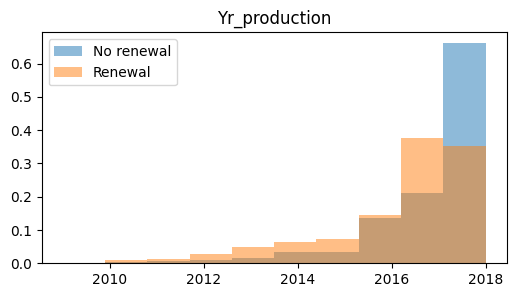

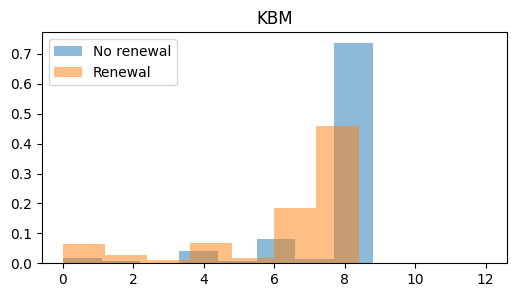

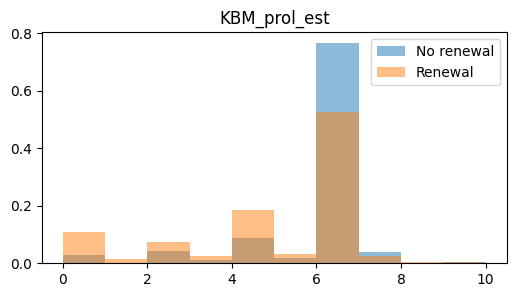

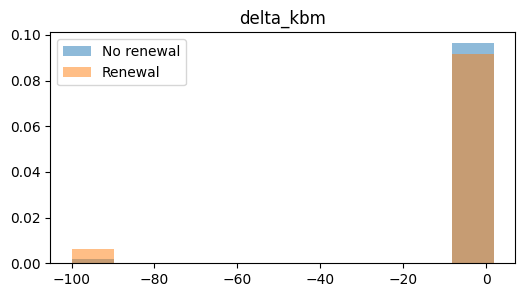

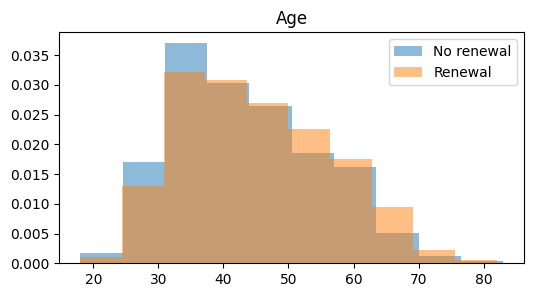

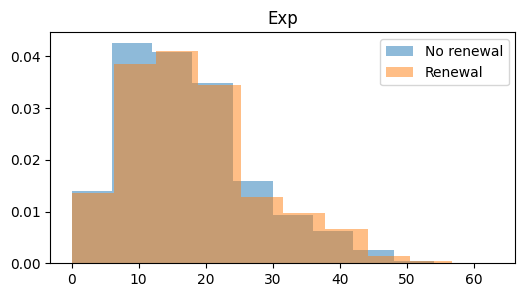

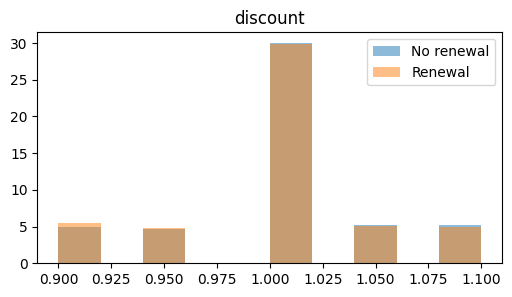

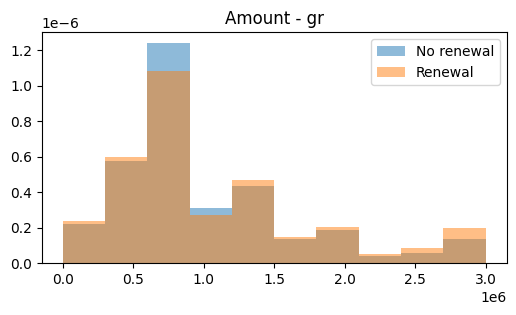

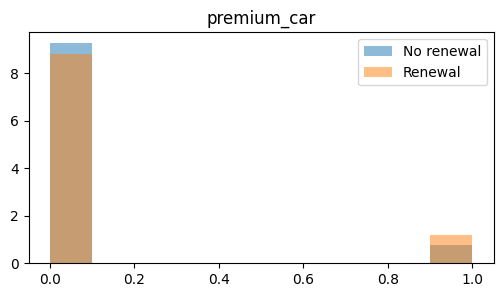

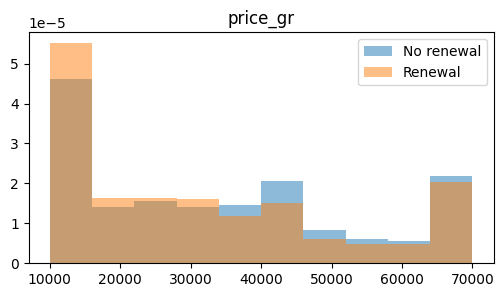

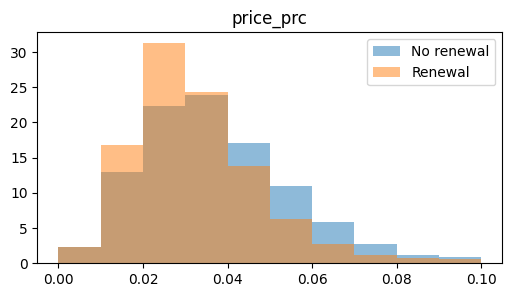

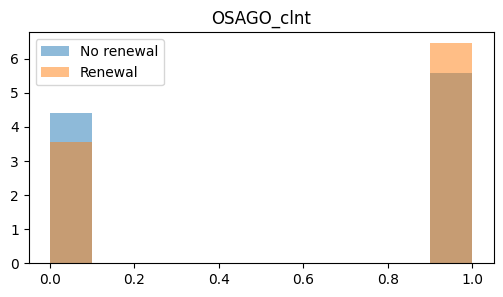

In [16]:
plot_list = numeric_info.index.tolist()
for feature in plot_list:
  plot_numeric_variable(train, feature)

Числовые переменные имеет смысл трансформировать в бинарные:

* Yr_production - до/ после 2018
* KBM - больше или равно 8/ меньше 8
* KBM_prol_est - больше или равно 6/ меньше 6
* delta_kbm - -100/ прочие
* Age - больше или равно 38/ меньше 38
* Exp - больше или равно 13/ меньше 13
* discount - 0.90/ прочие
* Amount - gr - суммы между 600 тыс и 1.2 млн./ прочие
* premium_car - без изменений
* price_gr - меньше 35000/ больше или равно 35000
* price_prc - меньше или равно 0.04/ больше 0.04
* OSAGO_clnt - без изменений

In [17]:
def transform_numeric_variables(data):
  data['Yr_production'] = np.where(data['Yr_production'] == 2018, 0, 1)
  data['KBM'] = np.where(data['KBM'] >= 8, 0, 1)
  data['KBM_prol_est'] = np.where(data['KBM_prol_est'] < 6, 1, 0)
  data['delta_kbm'] = np.where(data['delta_kbm'] == -100, 1, 0)
  data['Age'] = np.where(data['Age'] >= 38, 1, 0)
  data['Exp'] = np.where(data['Exp'] >= 13, 1, 0)
  data['discount'] = np.where(data['discount'] == 0.9, 1, 0)
  data['Amount - gr'] = np.where(
      (data['Amount - gr'] >= 6e05) & (data['Amount - gr'] < 1.2e06), 0, 1
  )
  data['price_gr'] = np.where(data['price_gr'] < 35000, 1, 0)
  data['price_prc'] = np.where(data['price_prc'] <= 0.04, 1, 0)

  return data

In [18]:
train = transform_numeric_variables(train)
train[numeric_variables].corr()

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,premium_car,price_gr,price_prc,OSAGO_clnt
Yr_production,1.000000,0.617044,0.613537,0.184757,0.086202,0.034311,0.008532,0.083611,0.084309,0.357385,0.167412,0.146645
KBM,0.617044,1.000000,0.994316,0.299422,0.115928,0.074153,-0.003027,0.053160,0.110454,0.130612,0.005598,0.142547
KBM_prol_est,0.613537,0.994316,1.000000,0.301134,0.116354,0.076679,-0.002325,0.052356,0.106041,0.134920,0.007497,0.141695
delta_kbm,0.184757,0.299422,0.301134,1.000000,0.058441,0.051244,-0.001474,0.026070,0.011784,0.121807,-0.008927,0.041844
Age,0.086202,0.115928,0.116354,0.058441,1.000000,0.487692,-0.006583,0.071637,0.011750,0.084519,0.137008,0.070076
Exp,0.034311,0.074153,0.076679,0.051244,0.487692,1.000000,0.003324,0.086511,0.067789,0.071123,0.181193,0.057914
discount,0.008532,-0.003027,-0.002325,-0.001474,-0.006583,0.003324,1.000000,-0.033536,-0.013999,0.004932,-0.016618,0.019676
Amount - gr,0.083611,0.053160,0.052356,0.026070,0.071637,0.086511,-0.033536,1.000000,0.246967,-0.124301,0.123553,0.044883
premium_car,0.084309,0.110454,0.106041,0.011784,0.011750,0.067789,-0.013999,0.246967,1.000000,-0.317829,0.076423,0.039956
price_gr,0.357385,0.130612,0.134920,0.121807,0.084519,0.071123,0.004932,-0.124301,-0.317829,1.000000,0.271729,0.064143


* KBM_prol_est почти идеально коррелирует с KBM - ее следует убрать из модели.

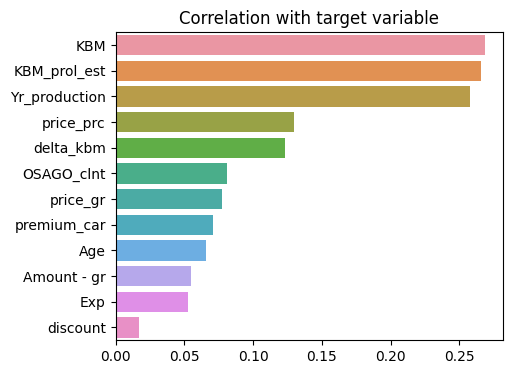

In [19]:
corr_with_target = (
    train[numeric_variables + [TARGET_NAME]]
    .corr()
    .iloc[:-1, -1]
    .sort_values(ascending=False)
)
plt.figure(figsize=(5, 4))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

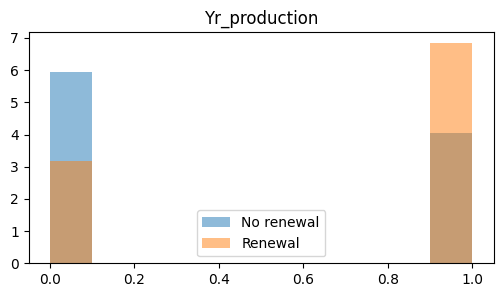

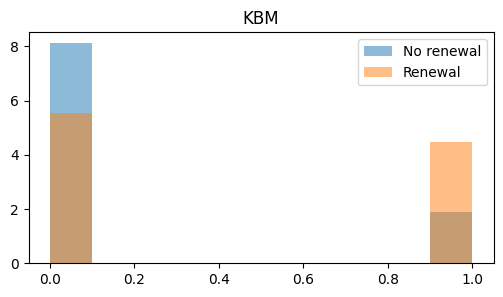

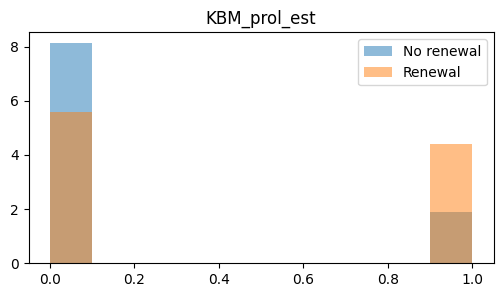

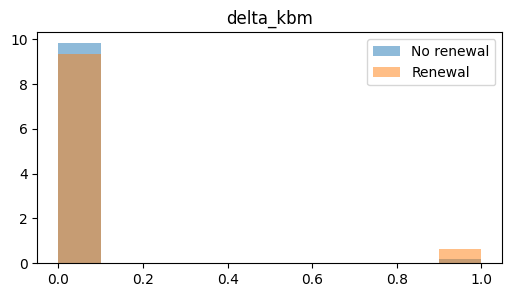

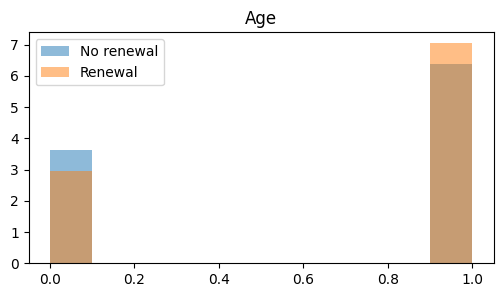

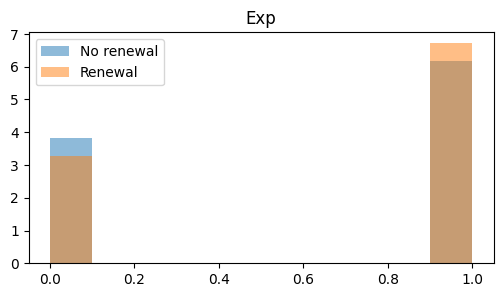

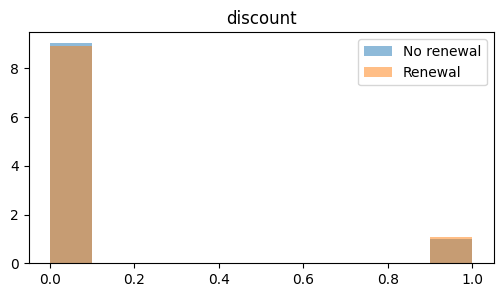

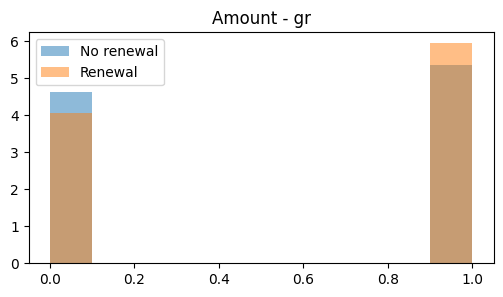

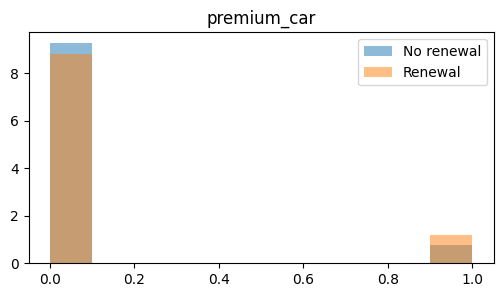

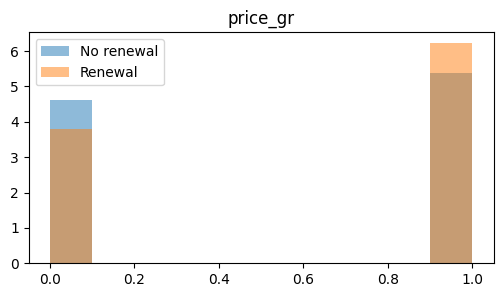

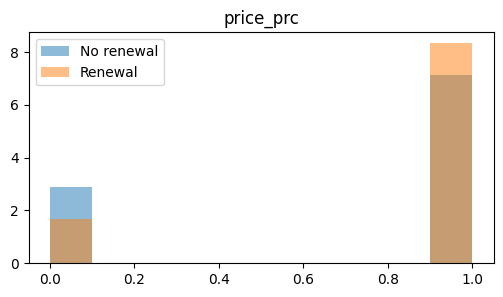

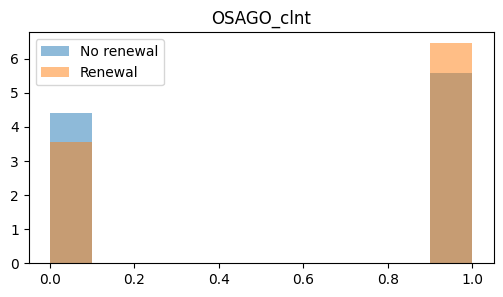

In [20]:
for feature in plot_list:
  plot_numeric_variable(train, feature)

## 5. Категориальные переменные

In [21]:
categorical_variables = train.dtypes[train.dtypes == 'object'].index.tolist()
categorical_info = train[categorical_variables].describe().T
categorical_info

,count,unique,top,freq
Filial,7598,22,Московский,2313
Type_ts,7598,2,Иностранные,5845
passport_region,7598,85,Москва,1129
VIP,208,2,Особый статус +,154
Brand,7598,23,LADA,1512
Model,7598,190,RIO,657
GAP,7598,2,Нет,6818
married,7598,2,Состоит в браке,5950
deduct,7598,3,Без франшизы,5025
deduct_amount,7598,3,0,5025


In [22]:
def plot_categorical_variable(data, feature, figsize=(6, 3)):
  train = data.copy()
  train[feature] = train[feature].fillna('No data')
  train.loc[train[feature] == 0, feature] = 'Zero'

  var_target_0 = train.loc[train[TARGET_NAME] == 0, feature]
  var_target_1 = train.loc[train[TARGET_NAME] == 1, feature]

  plt.figure(figsize=figsize)
  plt.hist(var_target_0, density=True, alpha=0.5, label='No renewal')
  plt.hist(var_target_1, density=True, alpha=0.5, label='Renewal')
  plt.title(feature)
  plt.legend();

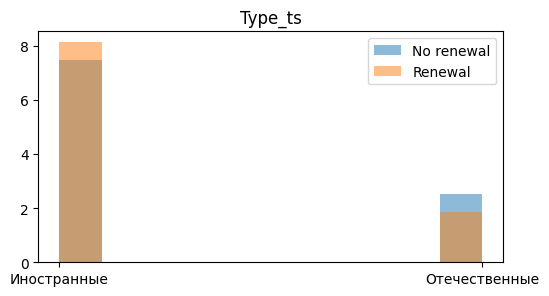

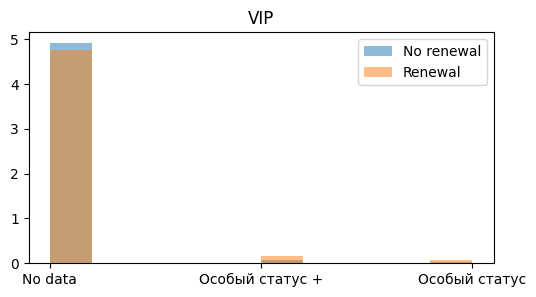

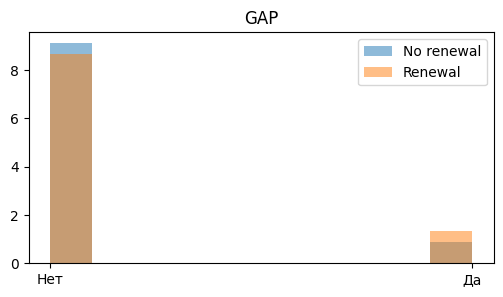

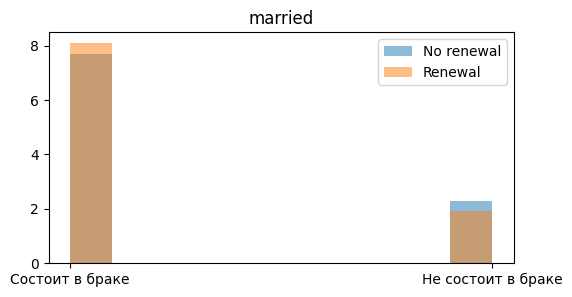

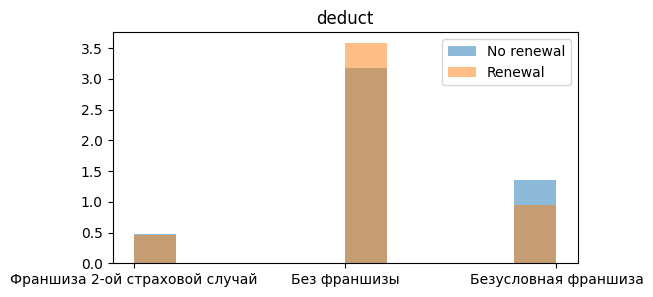

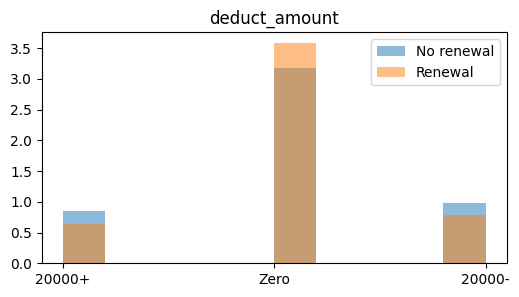

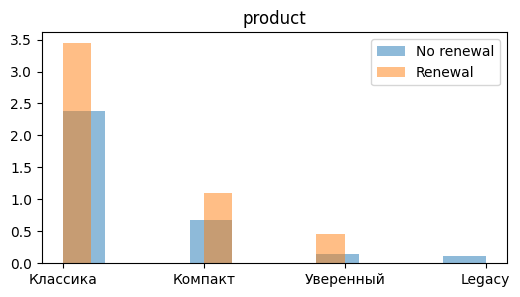

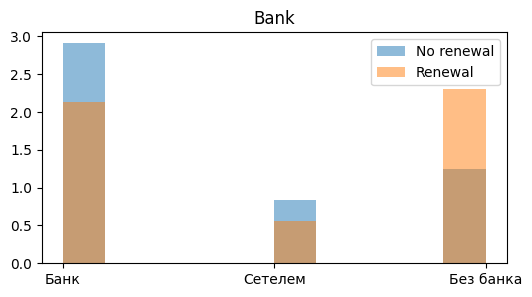

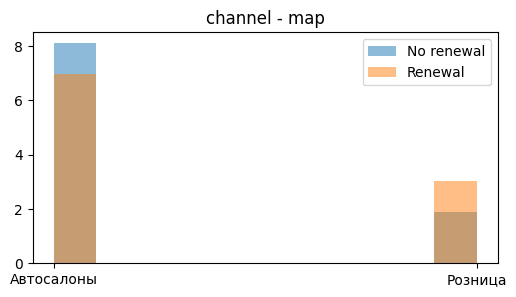

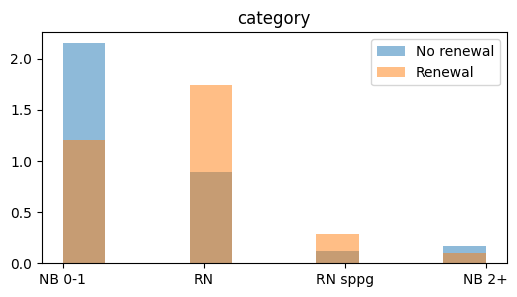

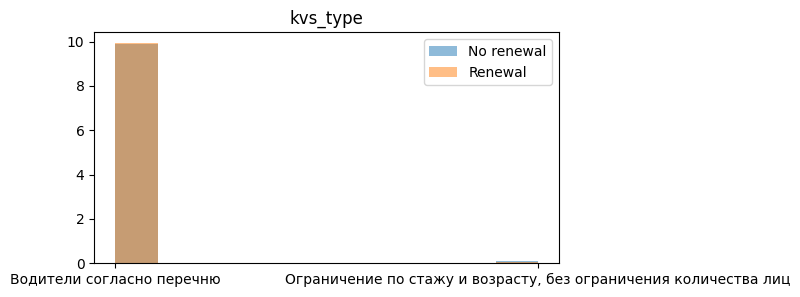

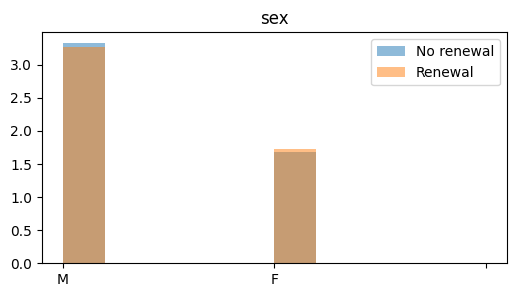

In [23]:
plot_list = categorical_info[categorical_info['unique'] < 10].index.tolist()
for feature in plot_list:
  plot_categorical_variable(train, feature)

Большую часть категориальных переменные имеет смысл трансформировать в бинарные:

* Type_ts - Иностранные/ Отечественные
* VIP - наличие/отсутствие особого статуса
* GAP - Да/ Нет
* deduct - Без франшизы/ прочие
* deduct_amount - отсутствие/ наличие deduct_amount
* product - Legacy/прочие
* Bank - Без банка/ прочие
* channel - map - Розница/ Автосалоны
* category - можно укрупнить NB/RN
* kvs_type - лучше убрать, неинформативный признак.
* sex и married - для большей информативности лучше объединить

In [24]:
def merge_features(data, feature_1, feature_2, new_feature):
  data.loc[:, new_feature] = (
    data.loc[:, [feature_1, feature_2]]
    .apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
  )
  return data

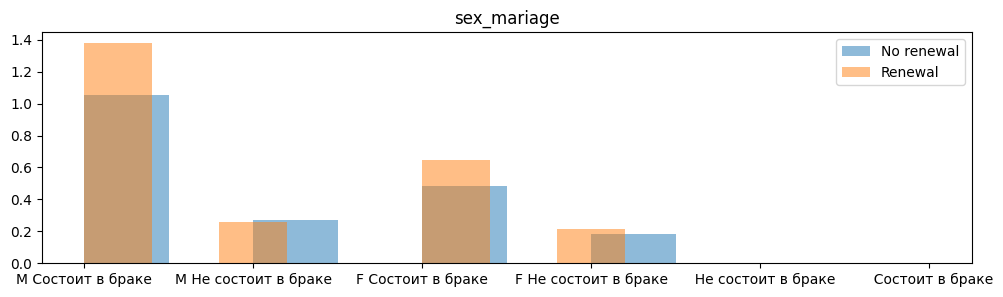

In [25]:
feature_1 = 'sex'
feature_2 = 'married'
new_feature = 'sex_mariage'

train = merge_features(train, feature_1, feature_2, new_feature)
plot_categorical_variable(train, new_feature, figsize=(12,3))

* Новые бинарные признаки: Cостоящие в браке мужчины и Cостоящие в браке женщины выглядят перспективно.

### 5.1. Филиал продажи и регион по серии паспорта

In [26]:
train = merge_features(train, 'Filial', 'passport_region', 'merged')
train['merged'].value_counts().head(30)

Московский Москва                              1112
Московский Московская область                   796
Краснодарский Краснодарский край                537
Санкт - Петербургский Санкт-Петербург           492
Ростовский Ростовская область                   342
Казанский Республика Татарстан                  283
Воронежский Воронежская область                 267
Самарский Самарская область                     263
Пермский Пермский край                          221
Ижевский Удмуртская Республика                  198
Челябинский Челябинская область                 195
Нижегородский Нижегородская область             172
Уфимский Республика Башкортостан                168
Тверской Тверская область                       156
Екатеринбургский Свердловская область           137
Волгоградский Волгоградская область             131
Магнитогорский Челябинская область              128
Ставропольский Ставропольский край              118
Кемеровский Кемеровская область                 109
Белгородский

In [27]:
regions = train['merged'].value_counts().head(27).index.tolist()
exclude_list = [
    'Магнитогорский Республика Башкортостан',
    'Краснодарский Республика Адыгея',
    'Московский Краснодарский край'
]
same_regions_list = [i for i in regions if not i in exclude_list]
same_regions_list

['Московский Москва',
 'Московский Московская область',
 'Краснодарский Краснодарский край',
 'Санкт - Петербургский Санкт-Петербург',
 'Ростовский Ростовская область',
 'Казанский Республика Татарстан',
 'Воронежский Воронежская область',
 'Самарский Самарская область',
 'Пермский Пермский край',
 'Ижевский Удмуртская Республика',
 'Челябинский Челябинская область',
 'Нижегородский Нижегородская область',
 'Уфимский Республика Башкортостан',
 'Тверской Тверская область',
 'Екатеринбургский Свердловская область',
 'Волгоградский Волгоградская область',
 'Магнитогорский Челябинская область',
 'Ставропольский Ставропольский край',
 'Кемеровский Кемеровская область',
 'Белгородский Белгородская область',
 'Новосибирский Новосибирская область',
 'Санкт - Петербургский Ленинградская область',
 'Тульский Тульская область',
 'Дальневосточный Приморский край']

In [28]:
train.loc[train['merged'].isin(same_regions_list), TARGET_NAME].mean()

0.3233981510997769

In [29]:
train.loc[~train['merged'].isin(same_regions_list), TARGET_NAME].mean()

0.2590634441087613

* Филиал продажи и регион по серии паспорта содержат похожую информацию, из двух признаков оставим только филиал продажи - он лучше обобщается.
* Введем новый бинарный признак: несоответствие/соответствие филиала продажи региону по серии паспорта

### 5.2. Brand & Model

#### 5.2.1. Уровень пролонгации полиса автострахования ниже среднего

In [30]:
mean_renewal = train.loc[:, TARGET_NAME].mean()
brands = train['Brand'].value_counts().index.tolist()
for brand in brands:
  brand_renewal = train.loc[train['Brand'] == brand, TARGET_NAME].mean()
  n_items = train['Brand'].value_counts()[brand]
  if brand_renewal < mean_renewal:
    print(f'{round(brand_renewal, 2)} \t{n_items} \t{brand}')

0.24 	1512 	LADA
0.25 	1332 	KIA
0.29 	1072 	HYUNDAI
0.21 	89 	DATSUN
0.26 	76 	UAZ


In [31]:
train = merge_features(train, 'Brand', 'Model', 'merged')
a = train['merged'].value_counts()
models = a[a>30].index.tolist()

for model in models:
  model_renewal = train.loc[train['merged'] == model, TARGET_NAME].mean()
  n_items = train['merged'].value_counts()[model]
  if model_renewal < mean_renewal:
    print(f'{round(model_renewal, 2)} \t{n_items} \t{model}')

0.25 	657 	KIA RIO
0.23 	495 	LADA GRANTA
0.24 	449 	HYUNDAI SOLARIS
0.24 	434 	LADA VESTA
0.25 	269 	VOLKSWAGEN POLO
0.27 	179 	LADA LARGUS
0.22 	156 	LADA XRAY
0.15 	116 	KIA OPTIMA
0.19 	100 	KIA SOUL
0.16 	100 	LADA 2121
0.16 	96 	KIA CEED
0.22 	78 	DATSUN ON-DO
0.26 	68 	RENAULT LOGAN
0.24 	67 	UAZ PATRIOT
0.15 	65 	TOYOTA CAMRY
0.15 	52 	KIA CERATO
0.29 	48 	KIA SORENTO
0.3 	47 	RENAULT KAPTUR
0.28 	46 	NISSAN TERRANO
0.31 	39 	FORD ECOSPORT
0.21 	33 	MITSUBISHI PAJERO SPORT
0.26 	31 	HYUNDAI ELANTRA


#### 5.2.2. Уровень пролонгации полиса автострахования выше среднего

In [32]:
brands = train['Brand'].value_counts().index.tolist()
for brand in brands:
  brand_renewal = train.loc[train['Brand'] == brand, TARGET_NAME].mean()
  n_items = train['Brand'].value_counts()[brand]
  if brand_renewal >= mean_renewal:
    print(f'{round(brand_renewal, 2)} \t{n_items} \t{brand}')

0.33 	638 	VOLKSWAGEN
0.32 	452 	TOYOTA
0.38 	387 	SKODA
0.45 	376 	NISSAN
0.37 	347 	RENAULT
0.37 	307 	FORD
0.36 	189 	CHEVROLET
0.34 	140 	MITSUBISHI
0.4 	124 	MAZDA
0.46 	123 	MERCEDES-BENZ
0.35 	108 	BMW
0.48 	100 	AUDI
0.44 	81 	LEXUS
0.59 	41 	VOLVO
0.49 	35 	SUBARU
0.31 	32 	HONDA
0.42 	26 	LAND ROVER
0.45 	11 	PORSCHE


In [33]:
train = merge_features(train, 'Brand', 'Model', 'merged')
a = train['merged'].value_counts()
models = a[a>30].index.tolist()

for model in models:
  model_renewal = train.loc[train['merged'] == model, TARGET_NAME].mean()
  n_items = train['merged'].value_counts()[model]
  if model_renewal >= mean_renewal:
    print(f'{round(model_renewal, 2)} \t{n_items} \t{model}')

0.32 	380 	HYUNDAI CRETA
0.42 	272 	VOLKSWAGEN TIGUAN
0.32 	223 	KIA SPORTAGE
0.33 	206 	TOYOTA RAV 4
0.33 	174 	SKODA RAPID
0.34 	165 	CHEVROLET NIVA
0.38 	142 	SKODA OCTAVIA
0.39 	137 	FORD KUGA
0.45 	129 	NISSAN X-TRAIL
0.44 	129 	RENAULT DUSTER
0.5 	119 	NISSAN QASHQAI
0.41 	103 	MAZDA CX-5
0.36 	100 	HYUNDAI TUCSON
0.39 	96 	LADA KALINA
0.38 	94 	TOYOTA LAND CRUISER PRADO 150
0.36 	88 	RENAULT SANDERO
0.32 	76 	FORD FOCUS
0.36 	70 	MITSUBISHI OUTLANDER
0.33 	63 	TOYOTA LAND CRUISER
0.4 	47 	HYUNDAI SANTA FE
0.49 	39 	SKODA YETI
0.53 	36 	AUDI Q5
0.42 	31 	SUBARU FORESTER
0.32 	31 	VOLKSWAGEN JETTA
0.32 	31 	HONDA CR-V
0.42 	31 	LEXUS NX


* Для кодирования Brand и Model воспользуемся Generalized Linear Mixed Model Encoder

### 5.3. Трансформация категориальных переменных

In [34]:
def transform_categorical_to_binary(data):
  data['Type_ts'] = np.where(data['Type_ts']=='Иностранные', 1, 0)
  data['VIP'] = np.where(data['VIP'].notnull(), 1, 0)
  data['GAP'] = np.where(data['GAP']== 'Нет', 0, 1)
  data['deduct'] = np.where(data['deduct'] == 'Без франшизы', 1, 0)
  data['deduct_amount'] = np.where(data['deduct_amount'] == 0, 1, 0)
  data['product'] = np.where(data['product'] == 'Legacy', 0, 1)
  data['channel - map'] = np.where(data['channel - map'] == 'Розница', 1, 0)
  data['Bank'] = np.where(data['Bank'] == 'Без банка', 1, 0)
  data['category'] = np.where(data['category'].isin(['RN', 'RN sppg']), 1, 0)

  feature_1 = 'sex'
  feature_2 = 'married'
  new_feature = 'sex_mariage'
  data = merge_features(data, feature_1, feature_2, new_feature)

  data['M_married'] = np.where(
      (data['sex'] == 'M') & (data['married'] == 'Состоит в браке'), 1, 0
  )
  data['F_married'] = np.where(
      (data['sex'] == 'F') & (data['married'] == 'Состоит в браке'), 1, 0
  )

  return data.drop(['married', 'kvs_type', 'sex','sex_mariage'], axis=1)


def get_same_regions_list(data):
  train = data.copy()
  train = merge_features(train, 'Filial', 'passport_region', 'merged')
  regions = train['merged'].value_counts().head(27).index.tolist()
  exclude_list = [
    'Магнитогорский Республика Башкортостан',
    'Краснодарский Республика Адыгея',
    'Московский Краснодарский край'
  ]
  same_regions_list = [i for i in regions if not i in exclude_list]

  return same_regions_list


def get_diff_passport_region_feature(data, same_regions_list):
  data = merge_features(data, 'Filial', 'passport_region', 'merged')
  new_feature = 'diff_passport_region'
  data[new_feature] = 0
  data.loc[data['merged'].isin(same_regions_list), new_feature] = 1
  data.drop(['passport_region', 'merged'], axis=1, inplace=True)

  return data


def fit_transform_categorical_variables(train):
  train = transform_categorical_to_binary(train)
  same_regions_list = get_same_regions_list(train)
  train = get_diff_passport_region_feature(train, same_regions_list)

  glmm_encoder = ce.glmm.GLMMEncoder(cols=['Filial', 'Brand', 'Model'])
  train = glmm_encoder.fit_transform(train, y=train[TARGET_NAME])

  return train, same_regions_list, glmm_encoder

In [35]:
train = data[data[TARGET_NAME] != -1]
test = data[data[TARGET_NAME] == -1]

train = transform_numeric_variables(train)
train, same_regions_list, glmm_encoder = fit_transform_categorical_variables(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7598 entries, 0 to 7597
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    7598 non-null   int64  
 1   Filial                7598 non-null   float64
 2   Type_ts               7598 non-null   int64  
 3   VIP                   7598 non-null   int64  
 4   Brand                 7598 non-null   float64
 5   Model                 7598 non-null   float64
 6   Yr_production         7598 non-null   int64  
 7   GAP                   7598 non-null   int64  
 8   KBM                   7598 non-null   int64  
 9   KBM_prol_est          7598 non-null   int64  
 10  delta_kbm             7598 non-null   int64  
 11  deduct                7598 non-null   int64  
 12  deduct_amount         7598 non-null   int64  
 13  product               7598 non-null   int64  
 14  Bank                  7598 non-null   int64  
 15  channel - map        

* Переменные с корреляцией выше 0.5:

In [36]:
corr = train.corr()
for i in range(len(corr)):
  for j in range(i+1, len(corr)):
    if corr.iloc[i, j] > 0.5:
      print(f'{round(corr.iloc[i, j], 2)} \t{corr.index[i]} - {corr.columns[j]}')

0.72 	Brand - Model
0.62 	Yr_production - KBM
0.61 	Yr_production - KBM_prol_est
0.83 	Yr_production - category
0.99 	KBM - KBM_prol_est
0.75 	KBM - category
0.74 	KBM_prol_est - category
1.0 	deduct - deduct_amount


* Удаляем переменные с высокой корреляцией

In [37]:
train.drop(
    ['deduct_amount', 'KBM_prol_est', 'category', 'Brand'], axis=1, inplace=True
)
corr = train.corr()
for i in range(len(corr)):
  for j in range(i+1, len(corr)):
    if corr.iloc[i, j] > 0.5:
      print(f'{round(corr.iloc[i, j], 2)} \t{corr.index[i]} - {corr.columns[j]}')

0.62 	Yr_production - KBM


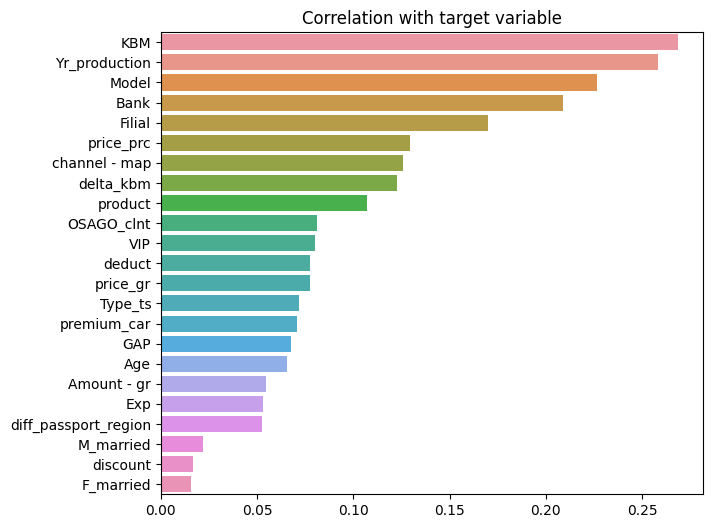

In [38]:
cols = [i for i in train.columns[1:] if i != TARGET_NAME]
corr_with_target = (
    train[cols + [TARGET_NAME]]
    .corr()
    .iloc[:-1, -1]
    .sort_values(ascending=False)
)
plt.figure(figsize=(7, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

## 6. Визуализация данных с помощью T-SNE проекций

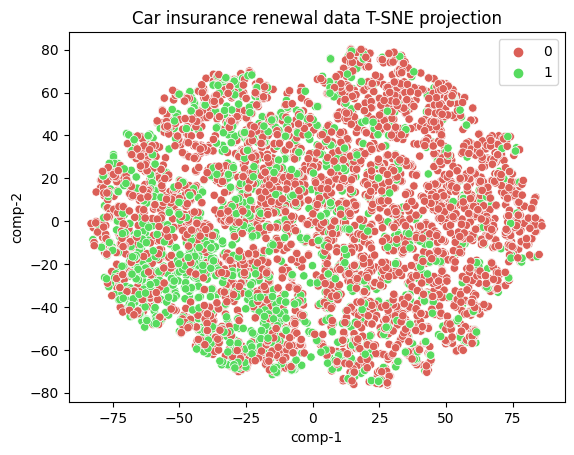

In [39]:
X_embedded = TSNE(
    n_components=2, learning_rate='auto', init='random',
).fit_transform(train[cols])

df = pd.DataFrame()
df[TARGET_NAME] = train[TARGET_NAME]
df["comp-1"] = X_embedded[:, 0]
df["comp-2"] = X_embedded[:, 1]

sns.scatterplot(
    x="comp-1", y="comp-2", hue=df[TARGET_NAME].tolist(),
    palette=sns.color_palette("hls", 3),
    data=df).set(title="Car insurance renewal data T-SNE projection"
);

* Визуально можно предположить, что данные обучающей выборки могут быль линейно разделимыми.

## 7. Кластерный анализ данных

In [40]:
clustering = DBSCAN(eps=0.5, min_samples=2).fit(train[cols])
train['clusters'] = clustering.labels_
train['clusters'].value_counts()

-1       3593
 21        60
 11        52
 58        34
 49        33
         ... 
 256        2
 638        2
 260        2
 636        2
 1001       2
Name: clusters, Length: 1003, dtype: int64

* По результатам кластерного анализа можно сделать допущение, что экземпляры данных относительно независимы, и что случаный компонент целевой переменной не коррелирует среди экземпляров обучающей выборки (предпосылка, встроенная в GLM).

## 8. Трансформация тестовых данных

In [41]:
def data_transform(test, same_regions_list, glmm_encoder):
  test = transform_numeric_variables(test)
  test = transform_categorical_to_binary(test)
  test = get_diff_passport_region_feature(test, same_regions_list)
  test = glmm_encoder.transform(test).drop(TARGET_NAME, axis=1)

  return test.drop(['deduct_amount', 'KBM_prol_est', 'category', 'Brand'], axis=1)

In [42]:
test = data_transform(test, same_regions_list, glmm_encoder)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3265 entries, 7598 to 10862
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    3265 non-null   int64  
 1   Filial                3265 non-null   float64
 2   Type_ts               3265 non-null   int64  
 3   VIP                   3265 non-null   int64  
 4   Model                 3265 non-null   float64
 5   Yr_production         3265 non-null   int64  
 6   GAP                   3265 non-null   int64  
 7   KBM                   3265 non-null   int64  
 8   delta_kbm             3265 non-null   int64  
 9   deduct                3265 non-null   int64  
 10  product               3265 non-null   int64  
 11  Bank                  3265 non-null   int64  
 12  channel - map         3265 non-null   int64  
 13  Age                   3265 non-null   int64  
 14  Exp                   3265 non-null   int64  
 15  discount         

### 8.1. Сравнение распределения переменных обучающей и тестовой выбоки.

In [43]:
def plot_train_test_distributions(group):
    fig, axes = plt.subplots(6, 4, figsize=(25, 24))

    for num, feature in enumerate(group):
        try:
            train_data, test_data = train[feature].copy(), test[feature].copy()
            sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
            sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
        except RuntimeError:
            pass
        except KeyError:
            train_data = train[feature].copy()
            sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")

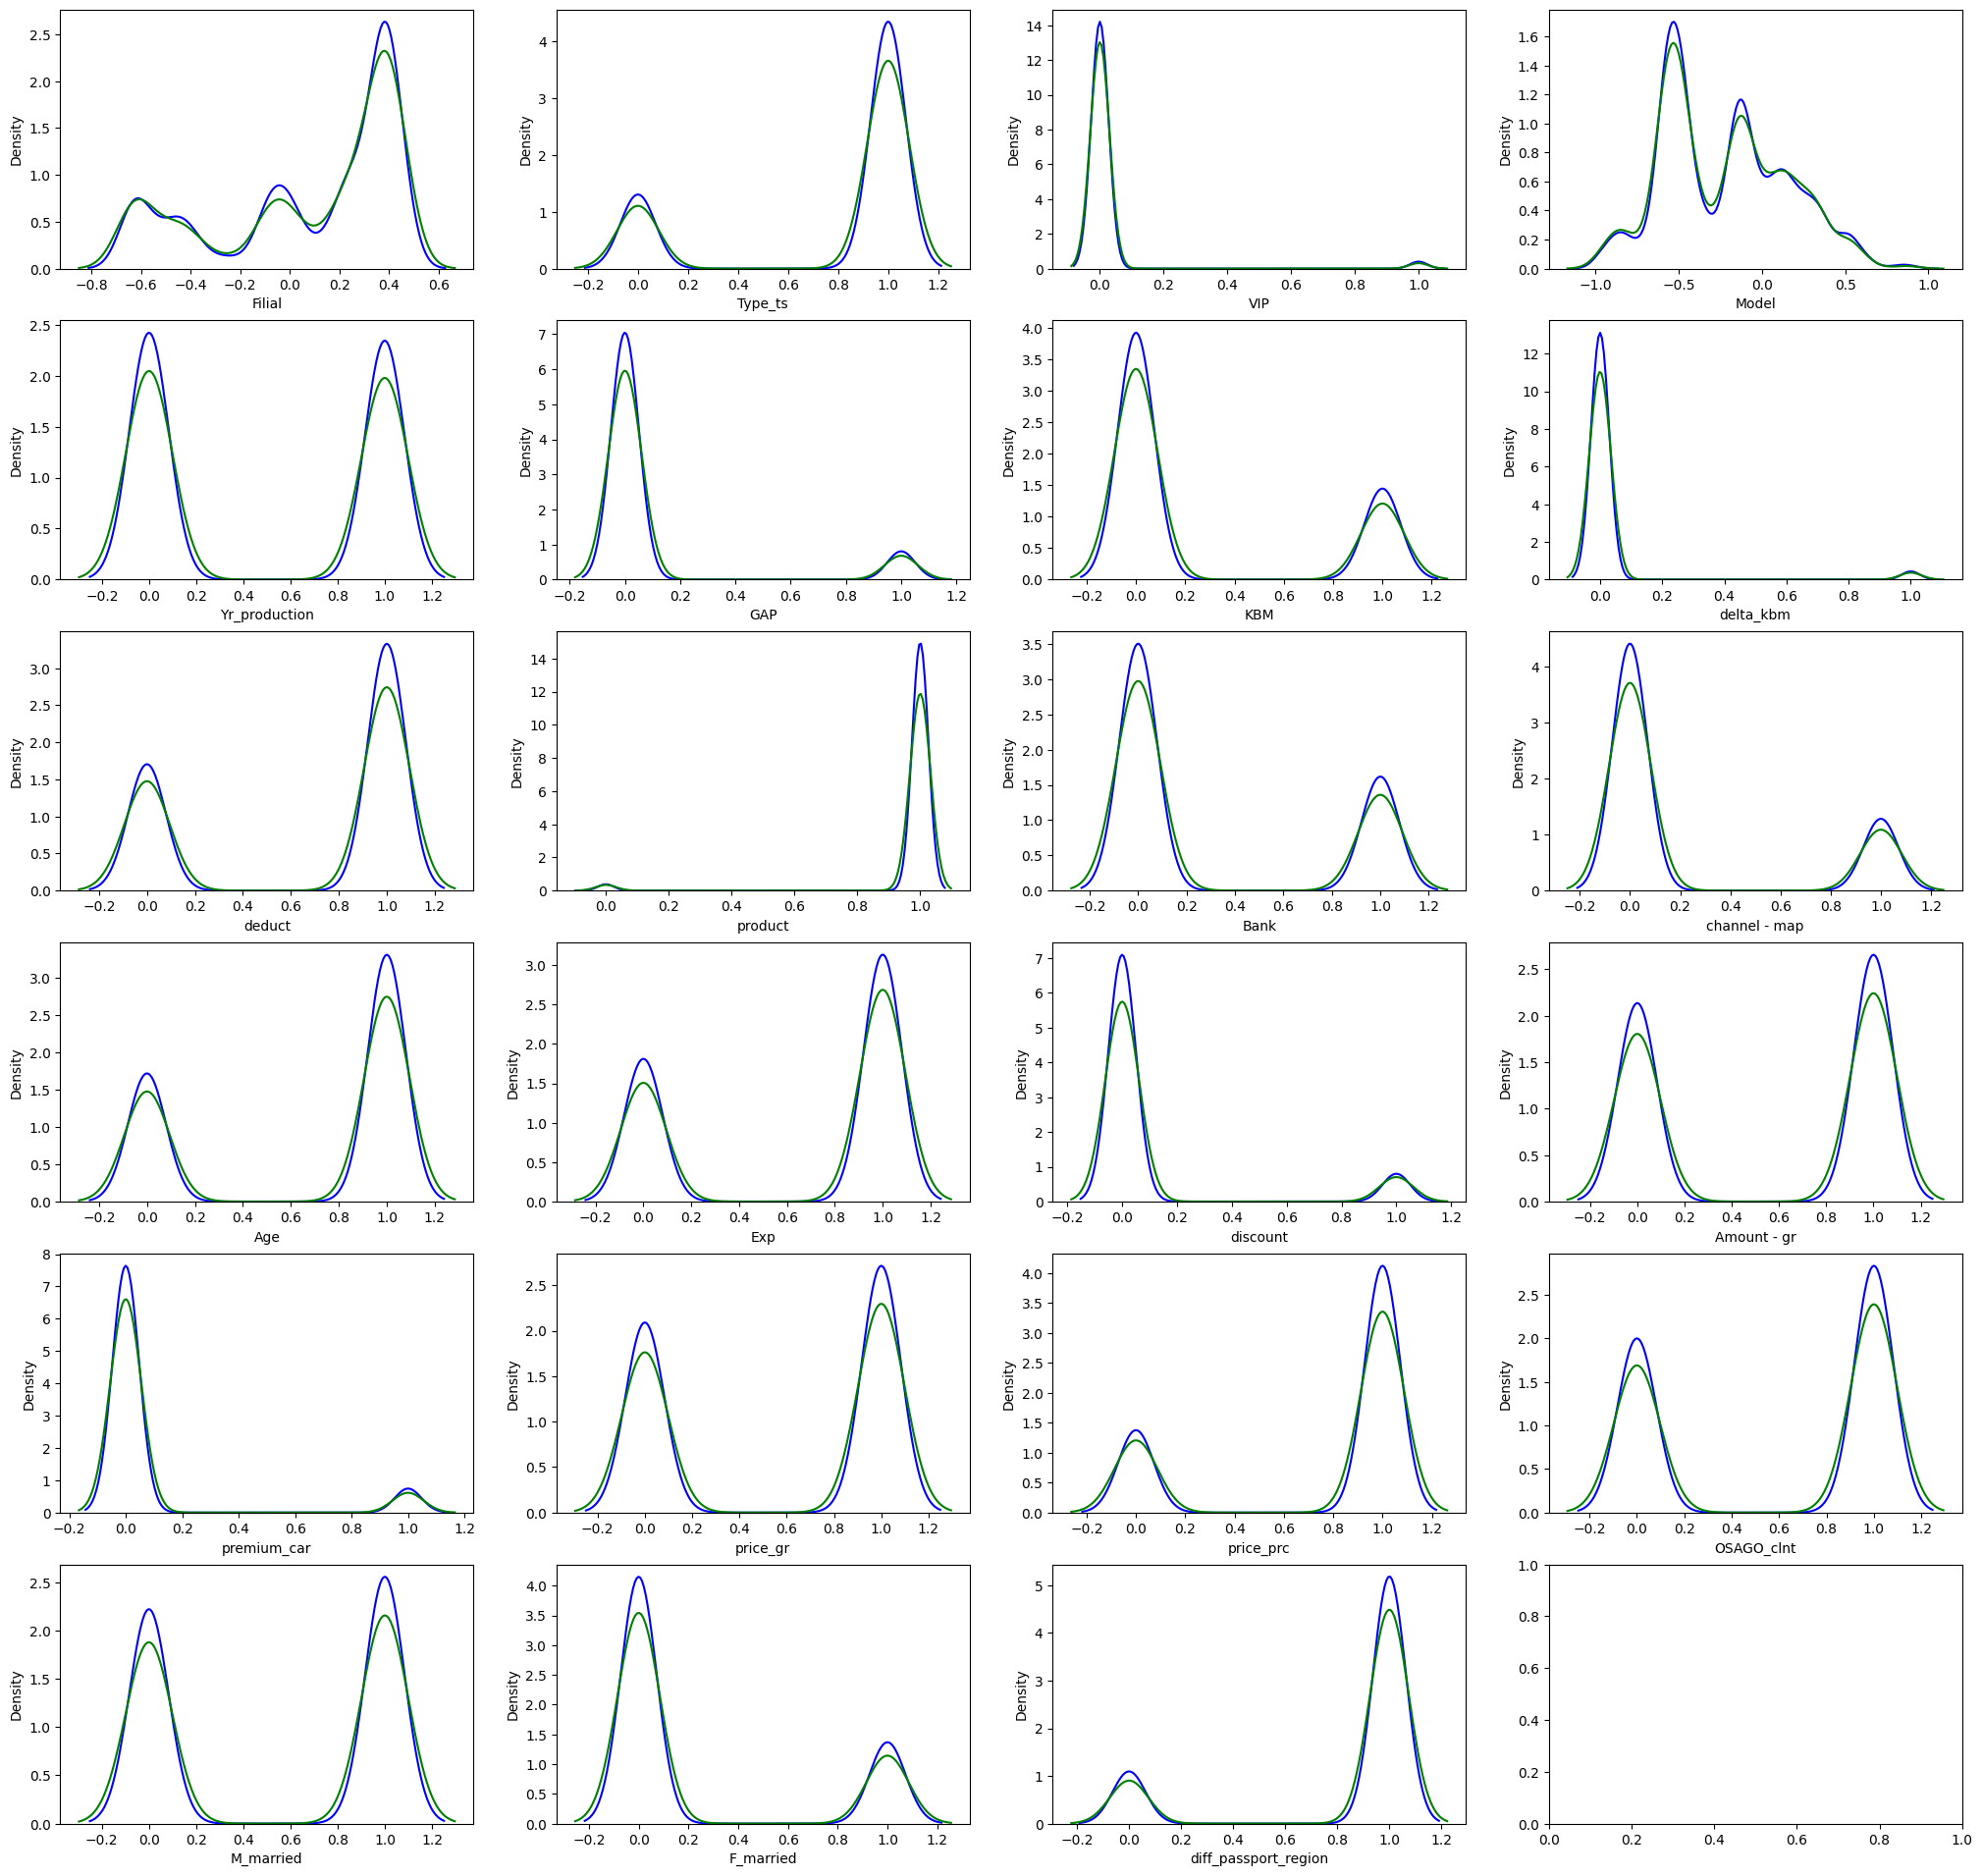

In [44]:
plot_train_test_distributions(cols)

* Распределения переменных обучающей и тестовой выборки, в целом, похожи.